In [138]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import regularizers


import tensorflow as tf
from tensorflow.keras import layers
import chess
import numpy as np


In [139]:
def fen_to_board(fen):
    # Parse the FEN string
    parts = fen.split(" ")
    board_part = parts[0]
    turn_part = parts[1]
    castling_part = parts[2]

    # Convert the board position to a binary matrix
    board = chess.Board(fen)
    binary_board = np.zeros((8, 8, 18), dtype=np.float32)
    pieces = {'p': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5,
              'P': 6, 'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11}
    
    for i in range(64):
        piece = board.piece_at(i)
        if piece:
            binary_board[i // 8, i % 8, pieces[str(piece)]] = 1.0

    # Add the turn to the binary matrix
    if turn_part == 'w':
        binary_board[..., 12] = 1.0
    else:
        binary_board[..., 13] = 1.0

    # Add the castling rights to the binary matrix
    if 'K' in castling_part:
        binary_board[..., 14] = 1.0
    if 'Q' in castling_part:
        binary_board[..., 15] = 1.0
    if 'k' in castling_part:
        binary_board[..., 16] = 1.0
    if 'q' in castling_part:
        binary_board[..., 17] = 1.0

    return binary_board


In [140]:
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(8, 8, 18)),  # Increase the number of filters
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Increase the number of filters
    layers.MaxPooling2D((2, 2)),
    Dropout(0.5),  # Dropout layer
    # layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # New convolutional layer
    # layers.MaxPooling2D((2, 2)),
    # Dropout(0.5),  # Dropout layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),  # Increase the number of neurons
    Dropout(0.5),  # Dropout layer
    layers.Dense(64, activation='relu'),  # Increase the number of neurons
    Dropout(0.5),  # Dropout layer
    layers.Dense(1)
])




model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


In [141]:
with open(r'fen_ratingsomate2.txt', 'r') as f:
    lines = f.readlines()

fens = [line.split()[0] + " " + line.split()[1] + " " + line.split()[2] for line in lines]
ratings = [int(line.split()[-1])/10000 for line in lines]


boards = np.array([fen_to_board(fen) for fen in fens])
ratings = np.array(ratings)

In [142]:
train_size = int(len(boards) * 0.7)
val_size = int(len(boards) * 0.15)

x_train, y_train = boards[:train_size], ratings[:train_size]
x_val, y_val = boards[train_size:train_size+val_size], ratings[train_size:train_size+val_size]
x_test, y_test = boards[train_size+val_size:], ratings[train_size+val_size:]


In [143]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 8, 8, 64)          │     10,432 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 4, 4, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_39 (Dropout)            │ (None, 4, 4, 64)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_36 (Conv2D)              │ (None, 4, 4, 128)         │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 2, 2, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_40 (Dropout)            │ (None, 2, 2, 128)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_16 (Flatten)            │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_38 (Dense)                │ (None, 128)               │     65,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_41 (Dropout)            │ (None, 128)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_39 (Dense)                │ (None, 64)                │      8,256 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_42 (Dropout)            │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_40 (Dense)                │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 158,273 (618.25 KB)

 Trainable params: 158,273 (618.25 KB)

 Non-trainable params: 0 (0.00 B)

In [144]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=30)

Epoch 1/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.0285 - loss: 0.0618 - val_accuracy: 0.0278 - val_loss: 0.0596
Epoch 2/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.0279 - loss: 0.0494 - val_accuracy: 0.0279 - val_loss: 0.0363
Epoch 3/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.0291 - loss: 0.0352 - val_accuracy: 0.0280 - val_loss: 0.0323
Epoch 4/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.0288 - loss: 0.0328 - val_accuracy: 0.0281 - val_loss: 0.0319
Epoch 5/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.0290 - loss: 0.0325 - val_accuracy: 0.0280 - val_loss: 0.0342
Epoch 6/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.0297 - loss: 0.0317 - val_accuracy: 0.0280 - val_loss: 0.0347
Epoch 7/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.0280 - loss: 0.0312 - val_accuracy: 0.0279 - val_loss: 0.0365
Epoch 8/30
3067/3067 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.0285 - loss: 0

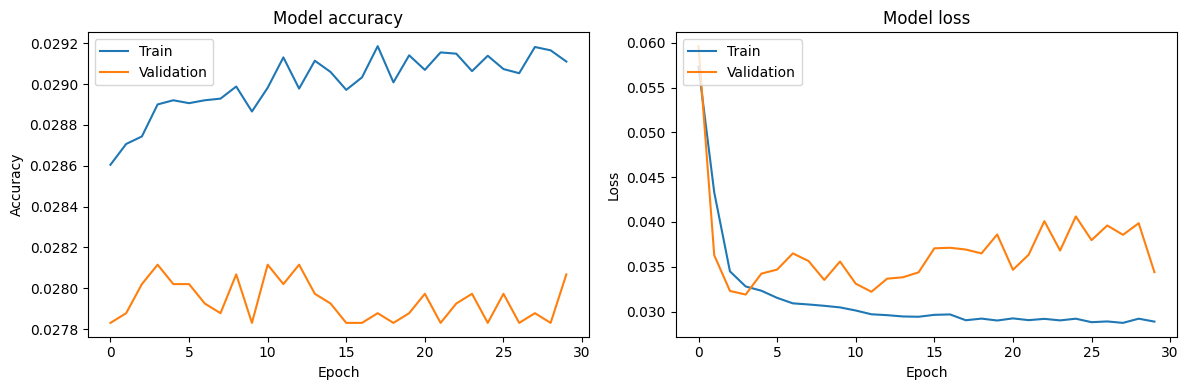

In [145]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [146]:
model.save('TrainedModel.h5')

In [147]:
# Predict the ratings for the test data
y_pred = model.predict(x_test)

# Print the predicted and true ratings for the test data
for i in range(min(len(x_test), 300)):
    print(f"Predicted rating: {y_pred[i]}, True rating: {y_test[i]}")


658/658 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Predicted rating: [-5.2660354e-05], True rating: 0.0005
Predicted rating: [-5.2660354e-05], True rating: 0.0088
Predicted rating: [-5.2660354e-05], True rating: 0.0074
Predicted rating: [-5.2660354e-05], True rating: 0.0057
Predicted rating: [-5.2660354e-05], True rating: 0.0062
Predicted rating: [-5.2660354e-05], True rating: 0.0536
Predicted rating: [-5.2660354e-05], True rating: 0.0228
Predicted rating: [-5.2660354e-05], True rating: 0.0431
Predicted rating: [-5.2660354e-05], True rating: -0.0482
Predicted rating: [-5.2660354e-05], True rating: -0.0478
Predicted rating: [-5.2660354e-05], True rating: -0.0546
Predicted rating: [-0.00092371], True rating: -0.053
Predicted rating: [-0.00061291], True rating: -0.0537
Predicted rating: [-0.00099617], True rating: -0.0542
Predicted rating: [-0.00386227], True rating: -0.0607
Predicted rating: [-0.00755434], True rating: -0.0578
Predicted rating: [-0.00755434], True rating: -0.0582
Predicted rating:

In [148]:
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')



2.15.0
No GPU found
